In [1]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

from sam.models import MultiHeadAttentionLayer, create_transformer, create_induction_head
from sam.dataset import get_dataloader

from configurations import load_data, make_params_dict, create_fig, set_font_sizes, apply_general_styles

apply_general_styles()


# Planted transformer?

In [7]:
config = {
    'vocab_size': 10,
    'seq_len': 20,
    'dropout': 0.0,
    'noise': 0.05
}

model , device = create_induction_head(config)


In [12]:
# Parameters
vocab_size = 40 # Vocabulary size
seq_len = 16  # Sequence length
batch_size = 16 # Batch size
dataset_size = 10000 # Dataset size
train_fraction = 0.8 # Fraction of data used for training
dropout = 0.0 # Dropout rate
noise = 0.05  # Noise level for parameter initialization

lr = 0.00001  # Learning rate



fix_names = ['vocab_size','seq_len','batch_size','dataset_size','train_fraction']
var_names = ['lr','dropout','noise']

params = make_params_dict(fix_names, var_names)
summary = load_data('summary',experiment_name='induction_head', params=params)

for key in summary:
    print(f'{key} : {summary[key].shape}')
    

File summary_dropout0_lr1e-05_noise0.05.pkl loaded with pickle.load from c:\Users\crise\OneDrive - SISSA\Documents\SISSA\SISSA 2nd YEAR\SAM\data\induction_head\batch_size16_dataset_size10000_seq_len16_train_fraction0.8_vocab_size40
step : (50,)
train_loss : (50,)
val_loss : (50,)
train_accuracy : (0,)
val_accuracy : (50,)


(0.0, 0.08695)

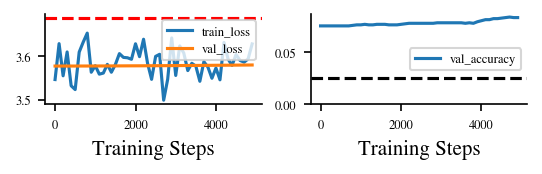

In [13]:
# Settings

set_font_sizes(conf='tight')

# Figure and plot
fig , axes = create_fig(ncols=2,h=0.3)

for ax , vars in zip(axes, [['train_loss','val_loss'], ['val_accuracy']]):
    for key in vars: 
        ax.plot('step', key, data=summary, label=key)
    ax.legend()
    ax.set_xlabel('Training Steps')
    
axes[0].axhline(y=math.log(vocab_size), color='r', linestyle='--')
axes[1].axhline(y=1/vocab_size, color='k', linestyle='--')
axes[1].set_ylim(bottom=0)

embedding.weight torch.Size([70, 70])
positions.weight torch.Size([10, 10])
WQ1.weight torch.Size([10, 80])
WK1.weight torch.Size([10, 80])
WV1.weight torch.Size([80, 80])
WQ2.weight torch.Size([70, 80])
WK2.weight torch.Size([70, 80])
WV2.weight torch.Size([70, 80])


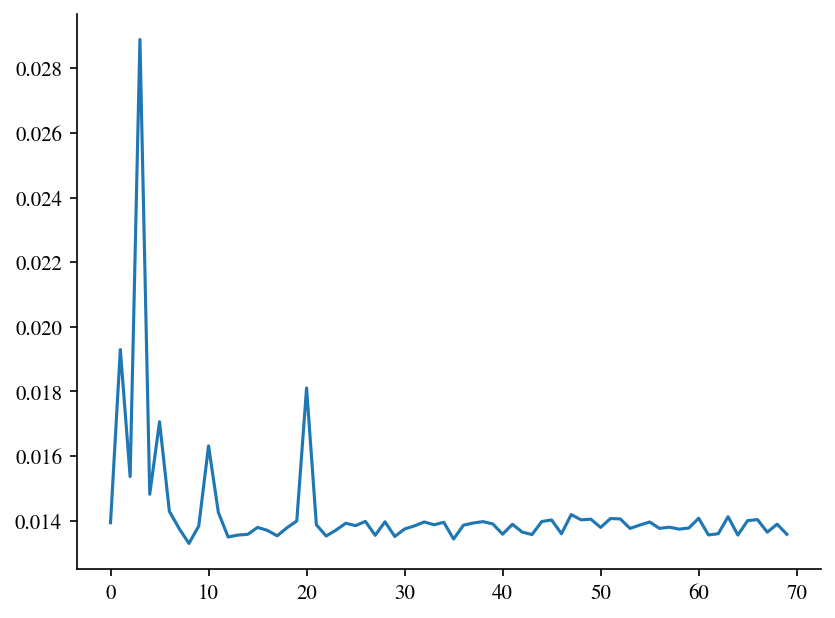

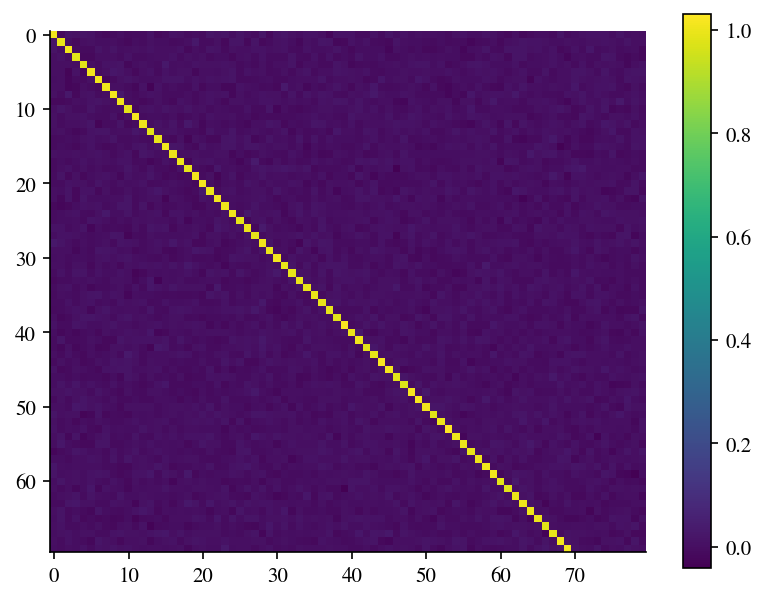

In [ ]:



V = 70
input = torch.tensor([1,20,3,10,5,3, 2, 4, 6 ,3]).unsqueeze(0)  # (1, 10)
L = input.shape[-1]

induction_head = InductionHeadAttention(V,L)

planted_initialization(induction_head,noise=0.01)

# Print all names of parameters in the model
for name, param in induction_head.named_parameters():
    print(name, param.shape)


output = induction_head(input)
probs = output.softmax(dim=-1)
# print(output.shape)

plt.plot(probs[0].detach().numpy().squeeze())
plt.show()
plt.imshow(induction_head.WV2.weight.detach().numpy(), cmap='viridis')
plt.colorbar()


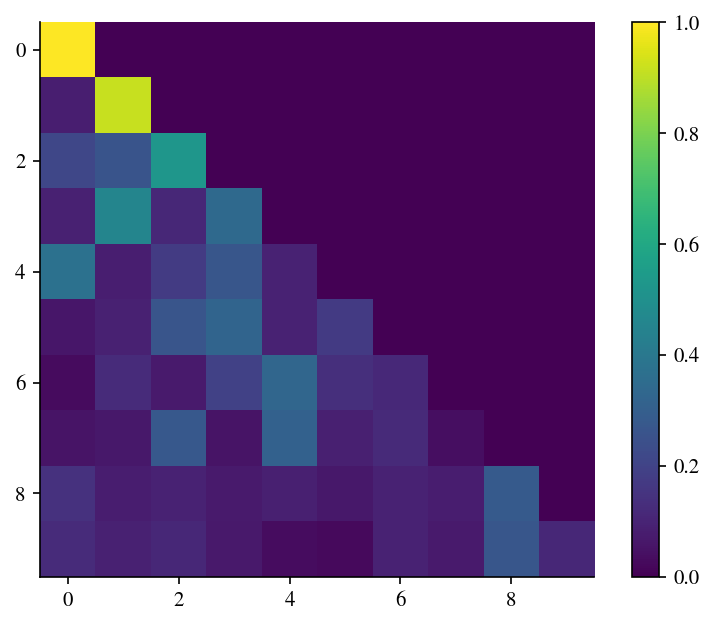

In [24]:
plt.imshow(output[0].detach().numpy(), cmap='viridis')
plt.colorbar()

torch.Size([10, 80]) torch.Size([80, 10]) torch.Size([80, 10])


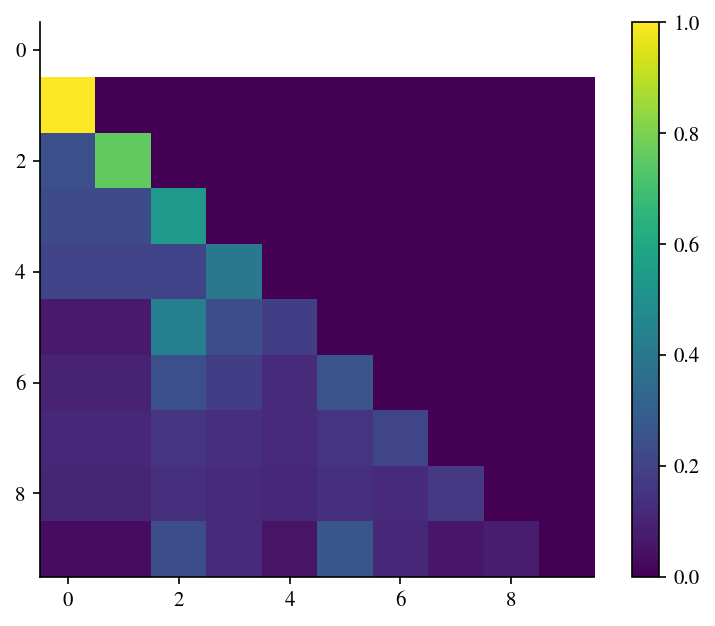

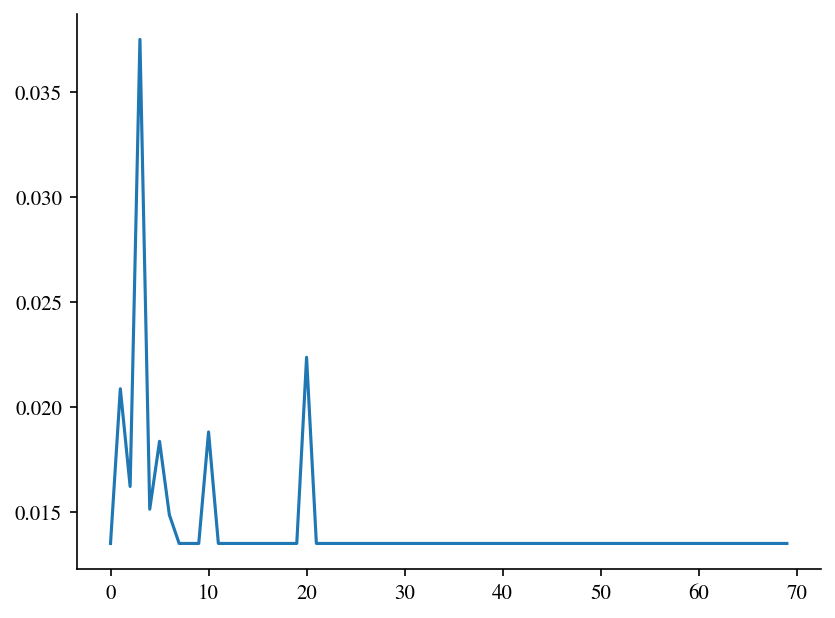

In [71]:


V = 70
input = torch.tensor([1,20,3,10,5,3, 2, 4, 6 ,3])
L = input.shape[0]
d = V + L
deff = L
beta1 = 1.0
beta2 = 1.0
beta_out = 1.0

E = torch.eye(V)
P = torch.eye(L)



# Make X = (E[input],P)  with shape (L, V+L)
X = torch.cat((E[input], P), dim=1)

Wq1 = torch.cat((torch.zeros((deff,V)), torch.eye(deff)), dim=1).T # shape (d, deff)
# Make S a shift matrix of shape (deff, deff)
S = torch.zeros((deff, deff))
S[1:,:-1] = torch.eye(L-1)

Wk1 = torch.cat((torch.zeros((deff,V)), S), dim=1).T # shape (d, deff)

print(X.shape, Wq1.shape, Wk1.shape) # (L , d) (d, deff) (d, deff)

Q1 = X @ Wq1 # shape (L, deff)
K1 = X @ Wk1 # shape (L, deff)

scores1 = beta1 * Q1 @ K1.T # shape (L, L)
masking = torch.tril(torch.ones((L,L))) == 0
scores1 = scores1.masked_fill(masking, float('-inf'))
att1 = scores1.softmax(dim=-1)

Wv1 = torch.zeros((d,d))
Wv1[:V,:V] = torch.eye(V)

V1 = X @ Wv1 # shape (L, d)
output1 = att1 @ V1 # shape (L, d)
Z1 = X + 2*output1 # shape (L, d)

# Second Layer

W = torch.cat((torch.eye(V), torch.zeros((V,L))), dim=1).T # shape (d, V)
Wq2 = W
Wk2 = W
Wv2 = W

Q2 = Z1 @ Wq2 # shape (L, V)
K2 = Z1 @ Wk2 # shape (L, V)
V2 = Z1 @ Wv2 # shape (L, V)

scores2 =  beta2 * Q2 @ K2.T # shape (L, L)
# Casual masking that includes diagonal
masking = torch.tril(torch.ones((L,L)),diagonal=-1) == 0
scores2 = scores2.masked_fill(masking, float('-inf'))
att2 = scores2.softmax(dim=-1)

output2 = att2 @ V2 # shape (L, V)
logits = beta_out * output2 @ E.T # shape (L, V)

prob = logits.softmax(dim=-1)

# plt.bar(np.arange(V),prob[-1].detach().numpy())

plt.imshow(att2.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()
plt.plot(prob[-1])


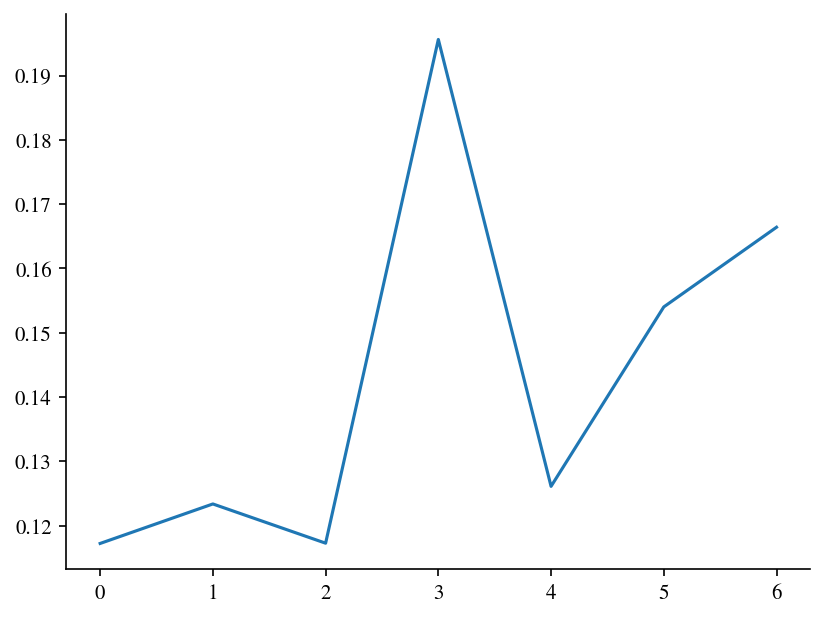

Prediction: tensor(3)


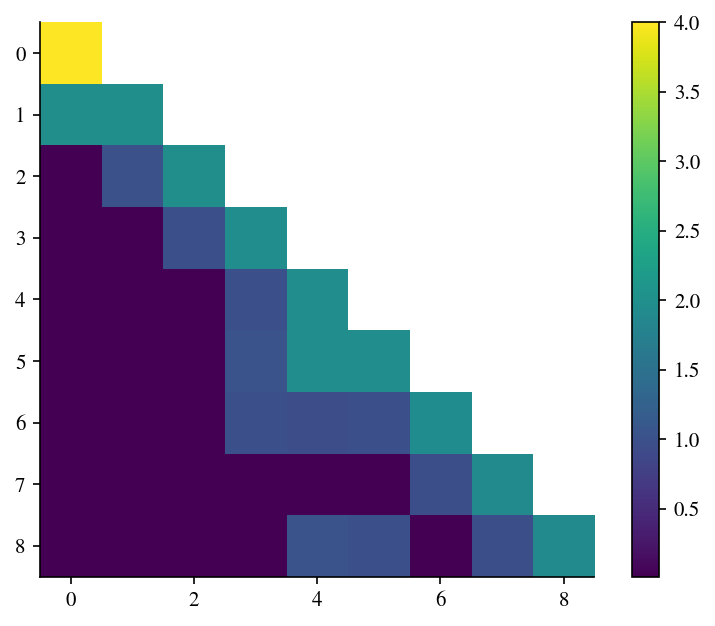

In [119]:

# masking = torch.tril(torch.ones((L,L))) == 0
scores2 = scores2.masked_fill(masking, float('-inf'))
att2 = scores2.softmax(dim=-1)

output2 = att2 @ V2 # shape (L, V)

logits = output2 @ E.T # shape (L, V)
preds = logits.argmax(dim=-1)
print("Prediction:", preds[-1])

plt.imshow(scores2.detach().numpy())
plt.colorbar()

#[0, 1, 4, 2 , 3, 5, 6, 2 , 1]

# Runs

In [89]:
d_model = 32
d_eff = 16
vocab_size = 20
seq_len = 16
batch_size = 64
dataset_size = 10000
train_fraction = 0.8
fr_emb = True

sigma = 0.2
lr = 0.0001
n_heads = 1
n_layers = 2
dropout = 0.1
sparsity = 0.0

fix_names = ['d_model','d_eff','vocab_size','seq_len','batch_size','dataset_size','train_fraction','fr_emb']
var_names = ['sigma','lr','n_heads','n_layers','dropout','sparsity']

params = make_params_dict(fix_names, var_names)
summary = load_data('summary',experiment_name='copy_task', params=params)

for key in summary:
    print(f'{key} : {summary[key].shape}')
    

File summary_dropout0.1_lr0.0001_n_heads1_n_layers2_sigma0.2_sparsity0.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/copy_task/batch_size64_d_eff16_d_model32_dataset_size10000_fr_embTrue_seq_len16_train_fraction0.8_vocab_size20
step : (50,)
train_loss : (50,)
val_loss : (50,)
train_accuracy : (0,)
val_accuracy : (50,)


(0.0, 0.119825)

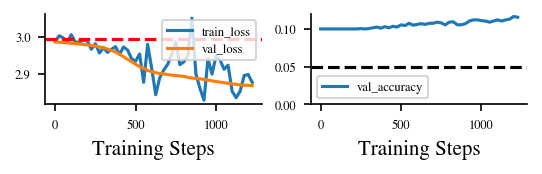

In [90]:
# Settings

set_font_sizes(conf='tight')

# Figure and plot
fig , axes = create_fig(ncols=2,h=0.3)

for ax , vars in zip(axes, [['train_loss','val_loss'], ['val_accuracy']]):
    for key in vars: 
        ax.plot('step', key, data=summary, label=key)
    ax.legend()
    ax.set_xlabel('Training Steps')
    
axes[0].axhline(y=math.log(vocab_size), color='r', linestyle='--')
axes[1].axhline(y=1/vocab_size, color='k', linestyle='--')
axes[1].set_ylim(bottom=0)

In [74]:
print(np.max(summary['val_accuracy']))
print(summary['step'][-1])

0.2305
61250


# Oth

In [13]:
config = {
    'd_model': 128,
    'd_eff': 32,
    'vocab_size': 100,
    'seq_len': 64,
    'n_heads': 3,
    'n_layers': 2,
    'dropout': 0.0,
    'sigma': 0.2,
    'batch_size': 16,
    'dataset_size': 1000,
    'train_fraction': 0.8,
    'lr': 1e-3,
}
model , device = create_transformer(config)
train_dataloader, val_dataloader = get_dataloader(config)


In [14]:
CE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'],eps=1e-9)

print(f'{math.log(config["vocab_size"]):.4f} bits per token')

for batch in train_dataloader:
    input = batch['input'].to(device)
    target = batch['target'].to(device)
    mask = batch['mask'].to(device)

    logits = model(input, mask)
    loss = CE_loss(logits.view(-1, config['vocab_size']), target.view(-1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print('Loss:', loss.item())





4.6052 bits per token
Loss: 4.588139057159424
Loss: 4.619813442230225
Loss: 4.606714725494385
Loss: 4.587735176086426
Loss: 4.588291645050049
Loss: 4.5869140625
Loss: 4.626347541809082
Loss: 4.627076625823975
Loss: 4.589531898498535
Loss: 4.587806224822998
Loss: 4.573376178741455
Loss: 4.556177139282227
Loss: 4.590441703796387
Loss: 4.623620986938477
Loss: 4.603174686431885
Loss: 4.614871501922607
Loss: 4.621535301208496
Loss: 4.6000237464904785
Loss: 4.5897746086120605
Loss: 4.555007457733154
Loss: 4.634619235992432
Loss: 4.516538619995117
Loss: 4.585512638092041
Loss: 4.455668926239014
Loss: 4.72534704208374
Loss: 4.5669403076171875
Loss: 4.765915393829346
Loss: 4.622761249542236
Loss: 4.678926467895508
Loss: 4.548009395599365
Loss: 4.610970497131348
Loss: 4.550774097442627
Loss: 4.58305025100708
Loss: 4.613428592681885
Loss: 4.632364273071289
Loss: 4.610985279083252
Loss: 4.59404993057251
Loss: 4.566056728363037
Loss: 4.613566875457764
Loss: 4.5711517333984375
Loss: 4.62340402603149

# Others

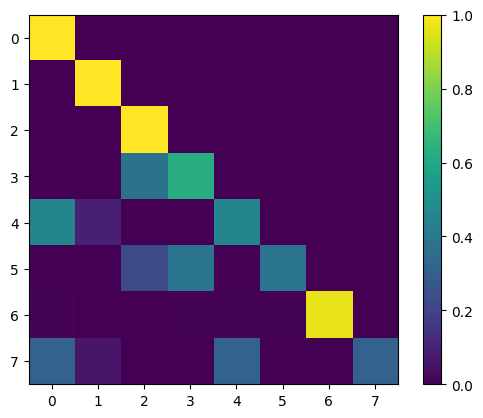

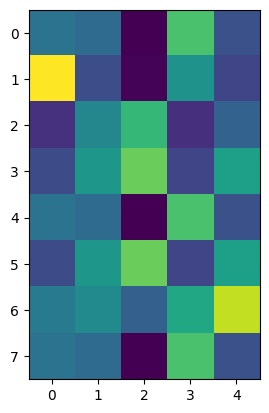

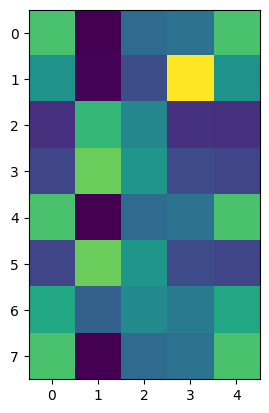

Predicted next token: 3


In [98]:
V = 5 # Vocabulary size
d = V # Embedding dimension for one-hot encoding
d_eff = 5 # Effective embedding dimension for Q, K, V
# embeddings = torch.eye(V, d) # One-hot encoding matrix
embeddings = torch.randn(V, d) # Random embedding matrix for demonstration
# Example of input sequence:
input = torch.tensor([1, 3, 0, 4, 1 , 4 , 2 , 1]) # Sequence of token indices
L = len(input) # Sequence length
# Positional encoding matrix (length L, dimension d) where all entries for position l are equal to l so that later positions have higher values

P = 0.*(L-torch.arange(L)).unsqueeze(1).repeat(1, d)/L
E = embeddings[input] # Embedded input sequence
X = E + P # One-hot encoded representation of the input sequence

Wq = torch.eye(d, d_eff) # Query projection matrix
Wk = torch.eye(d, d_eff) # Key projection matrix
Wv = torch.eye(d, d_eff) # Value projection matrix

Q = X @ Wq # Queries
K = X @ Wk # Keys

# Attention scores
S = Q @ K.transpose(-2, -1) 
# Causal mask to prevent attending to future tokens
mask = torch.tril(torch.ones(L,L)).bool()
S = S.masked_fill(~mask, float('-inf'))
A = torch.softmax(S, dim=-1) # Attention weights
# print(S)

plt.imshow(A.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

# Shifted value weigths so value i encodes token i+1
# Make it antydyagonal
Wv = torch.zeros(d, d_eff)
for i in range(d_eff):
    Wv[i, d_eff - i - 1] = 1.0
Wv = torch.roll(Wv, shifts=-1)
V = E @ Wv # Values

# print(E)
# print(Wv)
# print(V)
plt.imshow(E.detach().numpy(), cmap='viridis')
plt.show()
plt.imshow(V.detach().numpy(), cmap='viridis')
plt.show()


Y = A @ V # Output of the attention layer

# Wo also projection (identity here)
Wo = torch.eye(d_eff, d)
Y = Y @ Wo # Final output

y_last = Y[-1] # Output corresponding to the last input token
logits = y_last @ embeddings.transpose(0,1) # Logits for next token prediction
probs = torch.softmax(logits, dim=-1) # Probabilities for next token prediction
predicted_token = torch.argmax(probs).item() # Predicted next token
print(f"Predicted next token: {predicted_token}")

(7626,)


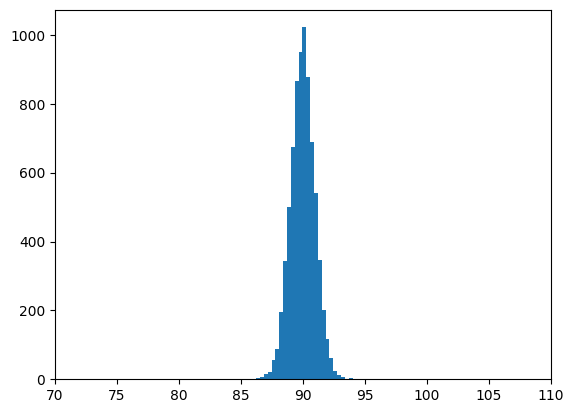

In [96]:
import numpy as np

n = 124
d = 500
d_eff = 60
X = np.random.randn(n,d)
W = np.random.randn(d,d_eff)
Y = X @ W /np.sqrt(d)
dot = Y @ Y.T/d # 
# get the elements just of the lower triangle, excluding the diagonal
elements = np.arccos(dot[np.tril_indices(n, k=-1)] ) * 180/np.pi
print(elements.shape)
plt.hist(elements, bins=30)
plt.xlim(70,110)
plt.show()